In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Reading the images

In [2]:
data_folder = "./sample_data"

## Loading Pre Trained Model

As we do not want the classification part, we select the last layer where we would want to extract information. We need to select after a trail and error or retrain the model (only the last layers).

In [3]:
# Loading pretrained Resnet model
model = models.resnet18(pretrained=True)
layer = model._modules.get('avgpool')

In [4]:
# Set model to evaluation mode as we plan to use pre trained model
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Transform the image to fit Resnet requirements

In [5]:
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

C:\Users\ravin\.conda\envs\fdh\lib\site-packages\torchvision\transforms\transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


## Converting image to vector

Steps
1. Loading the image
2. Transform the image
3. Create a zero vector to store the feature vector
4. Remap the output of resnet to select the elements from the layer we selected.

In [6]:
def get_vector(image_name):
    img = Image.open(image_name)
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    #    The 'avgpool' layer that we selected has an output size of 512
    my_embedding = torch.zeros(512)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.squeeze())
    h = layer.register_forward_hook(copy_data)
    model(t_img)
    h.remove()
    return my_embedding

In [7]:
def get_similarity(img1, img2):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_sim = cos(img1.unsqueeze(0), img2.unsqueeze(0))
    return cos_sim

In [8]:
image_list = glob.glob(data_folder+"/*.jpg")

In [9]:
no_of_imgs = len(image_list)
# matrix to store similarity
sim_mat = np.zeros((no_of_imgs, no_of_imgs))

In [10]:
img_features = []
for i, img_i in enumerate(image_list):
    img_vec_i = get_vector(img_i)
    img_features.append([img_i, img_vec_i.numpy()])
    for j, img_j in enumerate(image_list):
        if i == j:
            sim_mat[i][j] = sim_mat[j][i] = 0
        elif i > j:
            img_vec_j = get_vector(img_j)
            sim_mat[i][j] = sim_mat[j][i] = get_similarity(img_vec_i, img_vec_j)

In [11]:
sorted_inds = np.dstack(np.unravel_index(np.argsort(sim_mat.ravel()), sim_mat.shape))[0]

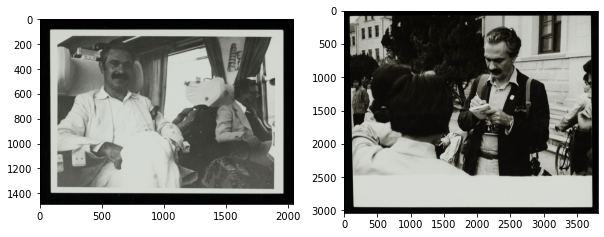

The similarity between these two images is 0.8448776006698608 



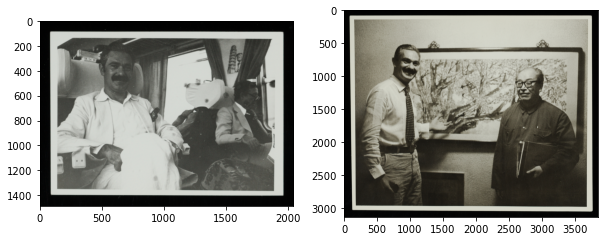

The similarity between these two images is 0.8261368274688721 



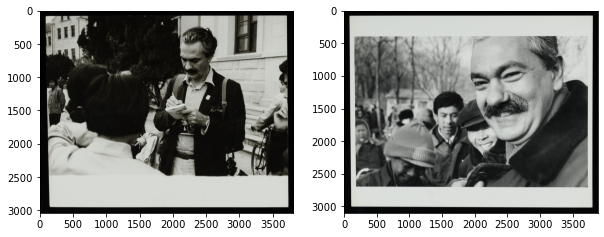

The similarity between these two images is 0.8243653774261475 



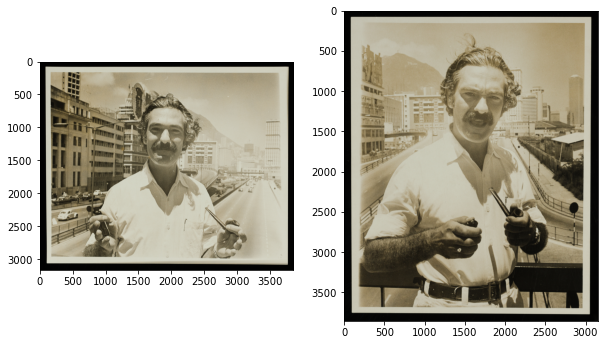

The similarity between these two images is 0.8161885738372803 



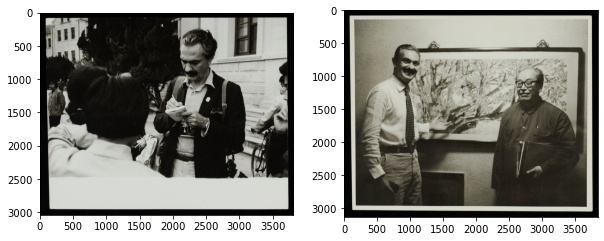

The similarity between these two images is 0.8127858638763428 



In [12]:
for iid_1, iid_2 in list(reversed(sorted_inds))[:10]:
    if iid_1 > iid_2:
            plt.figure(figsize=(10,8))
            img1 = Image.open(image_list[iid_1])
            img2 = Image.open(image_list[iid_2])
            plt.subplot(1,2,1)
            plt.imshow(img1)
            plt.subplot(1,2,2)
            plt.imshow(img2)
            plt.show()
            print("The similarity between these two images is {} \n".format(sim_mat[iid_1][iid_2]))        

In [20]:
images, features = map(list, zip(*img_features)) 

In [24]:
X = np.array(features)
tsne = TSNE(n_components=2, perplexity=5, angle=1.0, verbose=2).fit_transform(X)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 17 samples in 0.001s...
[t-SNE] Computed neighbors for 17 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 17 / 17
[t-SNE] Mean sigma: 4.247152
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 62.0161705, gradient norm = 0.4385483 (50 iterations in 0.011s)
[t-SNE] Iteration 100: error = 67.5939636, gradient norm = 0.6365597 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 80.7385864, gradient norm = 0.1087067 (50 iterations in 0.022s)
[t-SNE] Iteration 200: error = 78.2572479, gradient norm = 0.8861009 (50 iterations in 0.012s)
[t-SNE] Iteration 250: error = 52.7866898, gradient norm = 0.3000060 (50 iterations in 0.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.786690
[t-SNE] Iteration 300: error = 1.6174258, gradient norm = 0.0014418 (50 iterations in 0.012s)
[t-SNE] Iteration 350: error = 1.1531069, gradient norm = 0.0005519 (50 i

In [25]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

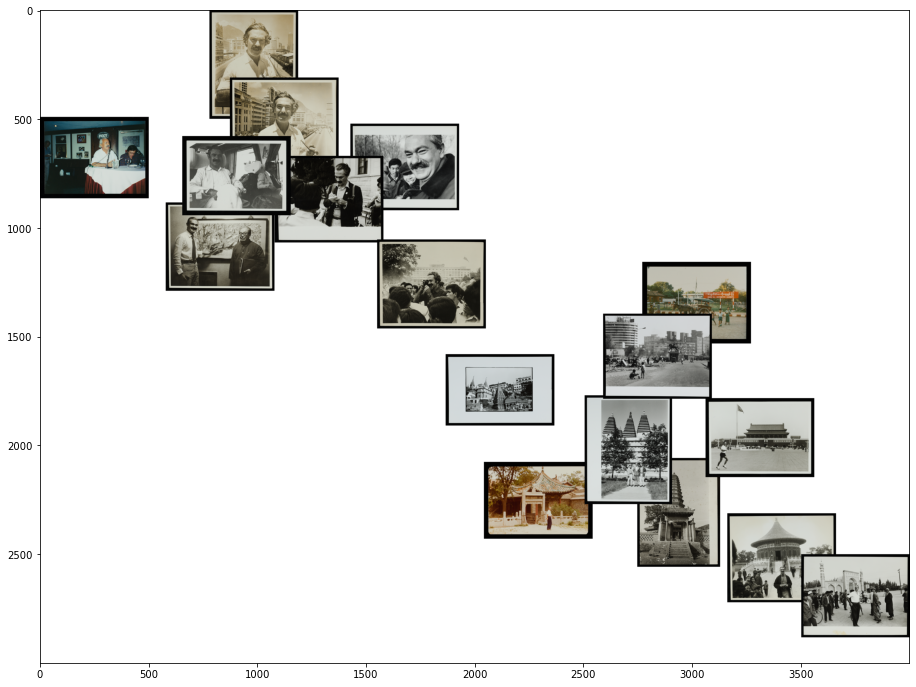

In [26]:
width = 4000
height = 3000
max_dim = 500

plt.figure(figsize = (16,12))

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))


plt.imshow(full_image)